In [1]:
from analysis.analysis import *
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
def heatmap(
    ax,
    F,
    bounds,
    labels,
    end_pts,
    xlabel=False,
    ylabel=False,
    cbar=False,
    cbar_label=False,
):
    xmin, xmax, vmin, vmax, nbins = bounds
    xmin, xmax = np.array([xmin, xmax]) - (xmax + xmin) / 2  # center along x
    ax.set_xlabel(r"$x$ ($\mu$m)") if xlabel else ...
    ax.set_ylabel(r"$v$ ($\mu$m/hr)") if ylabel else ...
    _kwargs = {
        "extent": [xmin, xmax, vmin, vmax],
        "origin": "lower",
        "cmap": "jet",
        "interpolation": "bilinear",
    }
    im = ax.imshow(F, **_kwargs)
    if cbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_ticks([-1000, 0, 1000])
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    cbar.set_label(r"$F$ ($\mu$m/hr$^2$)") if cbar_label else ...
    ax.set_aspect("auto")


def clean_init_pts(pts, labels, nuke):
    df = pd.DataFrame({"x": pts[:, 0], "y": pts[:, 1], "color": labels})
    if nuke:
        df = df.drop(df.query("y < 30 and y > -30 and color == 'red'").index)

    return df[df.y < 160].reset_index(drop=True)


def streamplot(
    F,
    bounds,
    labels,
    end_pts,
    ax,
    title="",
    n_skip=1,
    zero_line=False,
    show_terminal=None,
    septx=False,
    darker_shade=False,
    mix_corn_salmon=False,
    ignore_wheat=False,
    include_red=True,
    nuke_red_in_middle=True,
    gid=None,
    **kwargs,
):
    xmin, xmax, vmin, vmax, nbins = bounds
    x_c = (xmax + xmin) / 2
    xmin, xmax = np.array([xmin, xmax]) - x_c  # center along x
    ax.set_xlabel(r"$x$ ($\mu$m)")
    ax.set_ylabel(r"$v$ ($\mu$m/hr)")

    X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
    init_pts = clean_init_pts(init_pts, labels, nuke_red_in_middle)
    print(f"All unique colors: {init_pts.color.unique()}")

    for lbl, pts in init_pts.groupby("color"):
        if lbl == "gainsboro":
            continue

        if lbl == "red" and not include_red:
            continue

        _pts = pts[["x", "y"]].values

        if lbl != "wheat" or ignore_wheat:
            _pts = _pts[::n_skip]
            if mix_corn_salmon:
                lbl = "cornflowerblue"

        if lbl == "wheat":
            lbl = "goldenrod"

        if darker_shade:
            if lbl == "cornflowerblue":
                lbl = "royalblue"
            elif lbl == "salmon":
                lbl = "tomato"
            else:
                pass

        stream_kwargs = {"color": lbl, "start_points": _pts} | kwargs
        ax.streamplot(X, Y, Y, F, **stream_kwargs)
        ax.set_title(title)
        if zero_line:
            ax.axhline(y=0, lw=1, color="black", zorder=0)

        if show_terminal is not None:
            color = show_terminal.get("color", "black")
            s = show_terminal.get("size", 50)
            interior = show_terminal.get("interior", False)

            if interior:
                xy = (
                    pd.DataFrame({"x": end_pts[:, 0], "y": end_pts[:, 1]})
                    .query("x < 165 and x > 135 and y < 20 and y > -20")
                    .values
                )
                ax.scatter(
                    xy[:, 0] - x_c,
                    xy[:, 1],
                    s=s,
                    color=color,
                    marker="x",
                    zorder=10,
                )
            else:
                ax.scatter(
                    end_pts[:, 0] - x_c,
                    end_pts[:, 1],
                    s=s,
                    color=color,
                    marker="x",
                    zorder=10,
                )

    if septx:
        xmin, xmax, vmin, vmax, nbins = bounds
        _, _, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
        init_pts_df = clean_init_pts(init_pts, labels, nuke_red_in_middle)
        init_pts = init_pts_df[["x", "y"]].values
        labels = init_pts_df.color.values

        img = lattice_to_image(init_pts, labels, bounds)
        if not mix_corn_salmon:
            # img = np.where(img == 1, 0, 1)
            sepX_1 = get_separatrices(
                img, levels=[1.5], origin="lower", extent=[xmin, xmax, vmin, vmax]
            )
            ax.plot(sepX_1[:, 0] - x_c, sepX_1[:, 1], lw=2, color="black")

        if np.any(np.where(img == 1)):
            arr = np.where(img == 1, 1, 0)  # cluster `wheat`
            # if gid == 133:
            #     arr[14:17, 15:19] = 1
            sepX_2 = get_separatrices(
                arr, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax]
            )
            ax.plot(sepX_2[:, 0] - x_c, sepX_2[:, 1], lw=2, color="black")


def dynamicsplot(ax, F, bounds, labels, end_pts, **kwargs):
    X, Y, init_pts = full_lattice(F, *bounds)

    # raw
    v, f = evaluate_F_v_x0(Y, F, bounds[-1])
    lim = np.fabs([v.min(), v.max()]).min()
    v_interp = np.linspace(-lim, lim, 30)
    f_interp = np.interp(v_interp, v, f)

    kwargs = {"lw": 2, "color": "black"} | kwargs
    ax.plot(v_interp, f_interp, "-o", **kwargs)
    ax.grid(which="major")
    ax.set_xlabel(r"$v$ ($\mu$m/hr)")
    ax.set_ylabel(r"$F(x\rightarrow 0)$ ($\mu$m/hr$^2$)")

In [3]:
def process_gid(gid):
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    if len(data["labels"]) > 0:
        return data["F"], data["bounds"], np.array(data["labels"]), data["end_pts"]
    return data["F"], data["bounds"]

In [4]:
kwargs = {
    "density": 10,
    "linewidth": 0.5,
    "arrowsize": 1.0,
    "integration_direction": "forward",
    "broken_streamlines": True,
}
nskip = 2
inline = False
render = lambda f: plt.show() if inline else plt.savefig(f)

---

### Fig 1

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue']


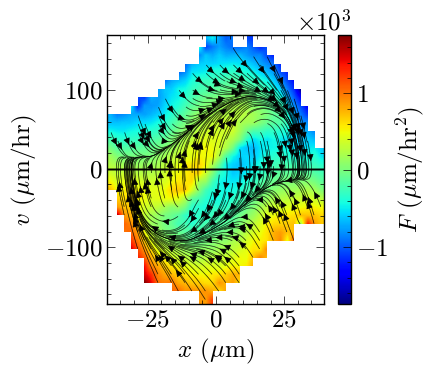

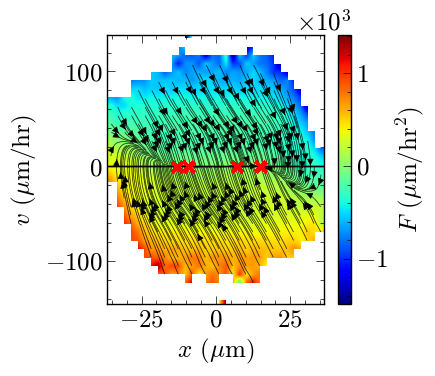

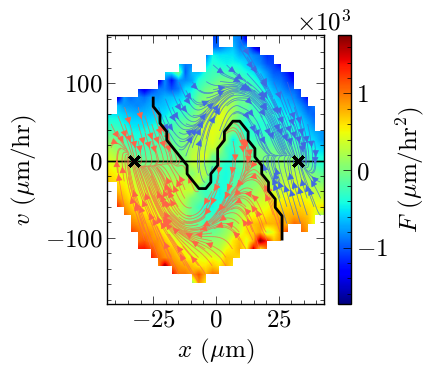

In [5]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-80, 170), fontsize=20)
heatmap(axs, *process_gid(10), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    *process_gid(10),
    axs,
    n_skip=nskip,
    zero_line=True,
    # show_terminal=True,
    **kwargs | {"color": "black"},
)
# plt.tight_layout()
render("paper_plots/limit_cycle_defaults.pdf")

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-75, 130), fontsize=20)
heatmap(axs, *process_gid(26), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    *process_gid(26),
    axs,
    n_skip=nskip,
    zero_line=True,
    ignore_wheat=True,
    show_terminal={"color": "red"},
    **kwargs | {"color": "black"},
)
# plt.tight_layout()
render(f"paper_plots/stationary_defaults.pdf")

nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows))
# axs.annotate("(iii)", xy=(0, 0), xytext=(-90, 150), fontsize=20)
heatmap(axs, *process_gid(2), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    *process_gid(2),
    axs,
    n_skip=nskip,
    zero_line=True,
    show_terminal={"color": "black"},
    septx=True,
    darker_shade=True,
    **kwargs,
)
# plt.tight_layout()
render(f"paper_plots/bistable_defaults.pdf")

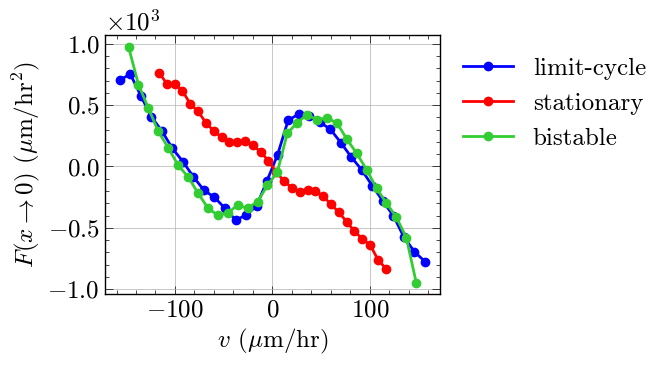

In [6]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(7 * ncols, 4 * nrows))
dynamicsplot(axs, *process_gid(10), color="blue", label="limit-cycle")
dynamicsplot(axs, *process_gid(26), color="red", label="stationary")
dynamicsplot(axs, *process_gid(2), color="limegreen", label="bistable")
axs.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
render("paper_plots/nonlinear_plots.pdf")

### Fig. 2

All unique colors: ['gainsboro' 'salmon' 'cornflowerblue']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'red' 'cornflowerblue' 'salmon']


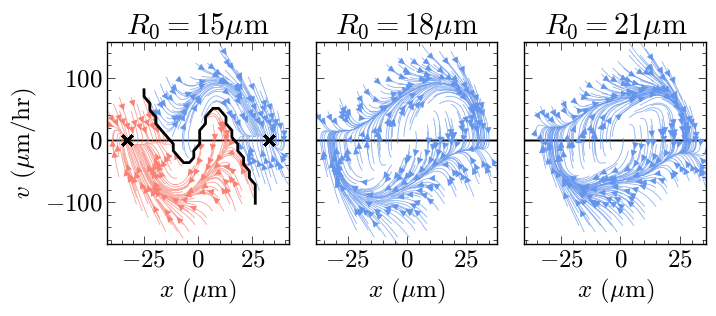

In [7]:
nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 3.5 * nrows), sharey=True)

streamplot(
    *process_gid(2),
    axs[0],
    title=r"$R_0=15\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    show_terminal={"color": "black"},
    septx=True,
    **kwargs
)
streamplot(
    *process_gid(10),
    axs[1],
    title=r"$R_0=18\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    **kwargs | {"color": "cornflowerblue"}
)
streamplot(
    *process_gid(122),
    axs[2],
    title=r"$R_0=21\mu\mathrm{m}$",
    n_skip=nskip,
    zero_line=True,
    **kwargs | {"color": "cornflowerblue"}
)
[axs[k].set_ylabel("") for k in range(1, 3)]

plt.tight_layout()
render("paper_plots/varying_cell_size_streams.pdf")

### Fig 3

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'salmon' 'red' 'cornflowerblue' 'wheat']


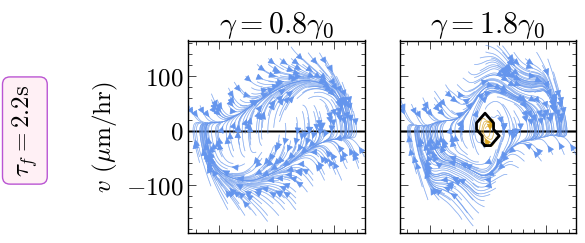

In [8]:
from matplotlib import colors


nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)

streamplot(
    *process_gid(10),
    axs[0],
    title=r"$\gamma=0.8\gamma_0$",
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    # include_red=False,
    **kwargs
)
streamplot(
    *process_gid(110),
    axs[1],
    title=r"$\gamma=1.8\gamma_0$",
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    septx=True,
    # include_red=True,
    **kwargs
)
axs[0].text(
    -110,
    0,
    r"$\tau_f=2.2$s",
    rotation=90,
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round",
        ec=colors.to_rgb("mediumorchid"),
        fc=colors.to_rgb("lavenderblush"),
    ),
)
axs[1].set_ylabel("")
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].tick_params(labelbottom=False)
axs[1].tick_params(labelbottom=False)
plt.subplots_adjust(wspace=0.2)
render("paper_plots/varying_cell_tension_streams_A.pdf")

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'wheat' 'salmon']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue' 'wheat']


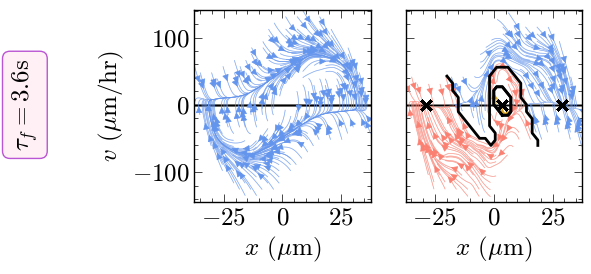

In [9]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)


streamplot(
    *process_gid(145),
    axs[0],
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    ignore_wheat=True,
    nuke_red_in_middle=False,
    **kwargs
)
streamplot(
    *process_gid(108),
    axs[1],
    n_skip=nskip,
    zero_line=True,
    show_terminal={"color": "black"},
    septx=True,
    **kwargs
)
axs[1].set_ylabel("")
axs[0].text(
    -110,
    0,
    r"$\tau_f=3.6$s",
    rotation=90,
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round",
        ec=colors.to_rgb("mediumorchid"),
        fc=colors.to_rgb("lavenderblush"),
    ),
)

plt.subplots_adjust(wspace=0.2)
render("paper_plots/varying_cell_tension_streams_B_noX.pdf")

### Fig 4

All unique colors: ['gainsboro' 'red' 'wheat' 'cornflowerblue' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon' 'wheat']
All unique colors: ['gainsboro' 'salmon' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'wheat']
All unique colors: ['gainsboro' 'red' 'wheat' 'cornflowerblue' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon' 'wheat']


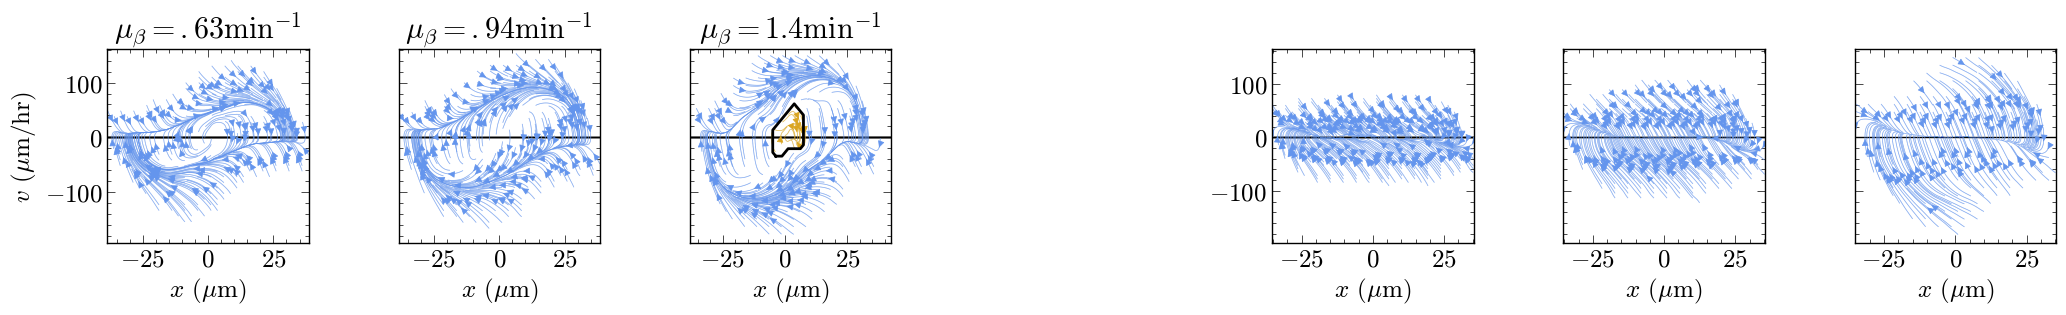

In [10]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

gids = [132, 10, 133, 10, 136, 26, 137]
titles = [
    r"$\mu_{\beta}=.63\mathrm{min}^{-1}$",
    r"$\mu_{\beta}=.94\mathrm{min}^{-1}$",
    r"$\mu_{\beta}=1.4\mathrm{min}^{-1}$",
]
# streams
for ax, gid, title in zip(axs[:3], gids[:3], titles):
    streamplot(
        *process_gid(gid),
        ax,
        title=title,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        **kwargs
    )

for ax, gid in zip(axs[4:], gids[4:]):
    streamplot(
        *process_gid(gid),
        ax,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        # show_terminal=True,
        ignore_wheat=True,
        **kwargs | {"color": "cornflowerblue"}
    )

axs[0].clear()
streamplot(
    *process_gid(gids[0]),
    axs[0],
    title=titles[0],
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    ignore_wheat=True,
    **kwargs
)

axs[2].clear()
streamplot(
    *process_gid(gids[2]),
    axs[2],
    title=titles[2],
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    septx=True,
    **kwargs
)

axs[3].remove()
[axs[k].set_ylabel("") for k in range(1, ncols)]
[axs[k].sharey(axs[0]) for k in [1, 2]]
[axs[k].tick_params(labelleft=False) for k in [1, 2]]
[axs[k].sharey(axs[-1]) for k in [4, 5, 6]]
[axs[k].tick_params(labelleft=False) for k in [5, 6]]

plt.tight_layout()
render("paper_plots/varying_mub_streams.pdf")

All unique colors: ['gainsboro' 'salmon' 'red' 'cornflowerblue' 'wheat']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'red' 'wheat']
All unique colors: ['gainsboro' 'wheat']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'red' 'wheat']
All unique colors: ['gainsboro' 'salmon' 'red' 'cornflowerblue' 'wheat']


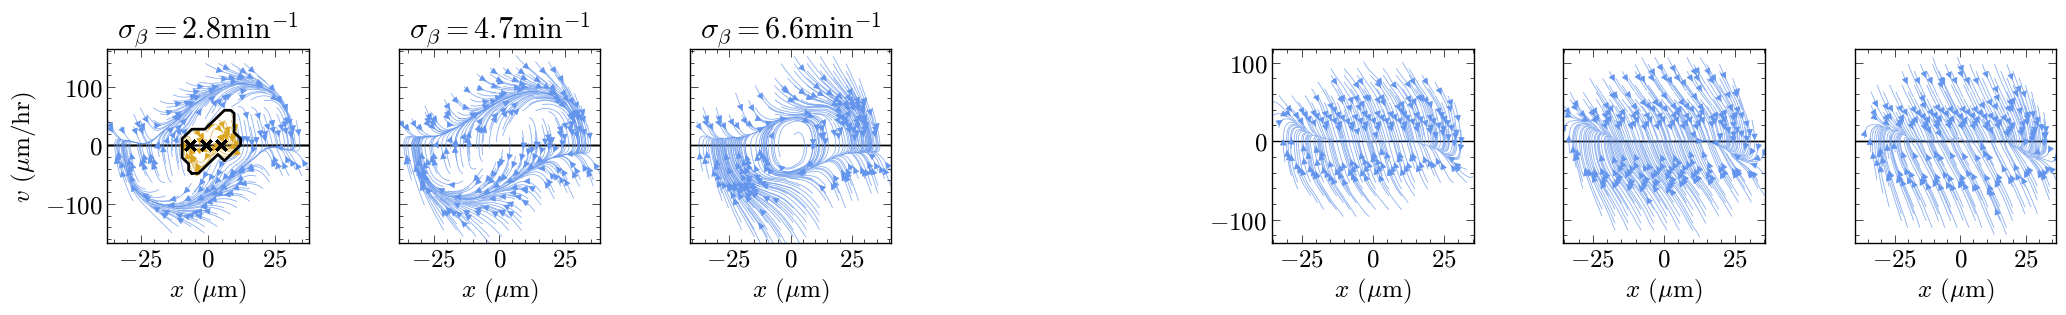

In [30]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

gids = [112, 10, 114, 10, 113, 26, 115]
titles = [
    r"$\sigma_{\beta}=2.8\mathrm{min}^{-1}$",
    r"$\sigma_{\beta}=4.7\mathrm{min}^{-1}$",
    r"$\sigma_{\beta}=6.6\mathrm{min}^{-1}$",
]

# streams
for ax, gid, title in zip(axs[:3], gids[:3], titles):
    streamplot(
        *process_gid(gid),
        ax,
        title=title,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        **kwargs
    )

for ax, gid in zip(axs[4:], gids[4:]):
    streamplot(
        *process_gid(gid),
        ax,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        # show_terminal=True,
        ignore_wheat=True,
        **kwargs | {"color": "cornflowerblue"}
    )

axs[2].clear()
streamplot(
    *process_gid(gids[2]),
    axs[2],
    title=titles[2],
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    ignore_wheat=True,
    **kwargs
)

axs[0].clear()
streamplot(
    *process_gid(gids[0]),
    axs[0],
    title=titles[0],
    n_skip=nskip,
    zero_line=True,
    mix_corn_salmon=True,
    septx=True,
    show_terminal={"color": "black", "interior": True},
    **kwargs
)

axs[3].remove()
[axs[k].set_ylabel("") for k in range(1, ncols)]
[axs[k].sharey(axs[0]) for k in [1, 2]]
[axs[k].tick_params(labelleft=False) for k in [1, 2]]
[axs[k].sharey(axs[-1]) for k in [4, 5, 6]]
[axs[k].tick_params(labelleft=False) for k in [5, 6]]

plt.tight_layout()
render("paper_plots/varying_sigmab_streams.pdf")

All unique colors: ['gainsboro' 'red' 'cornflowerblue' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue' 'wheat']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'salmon' 'wheat']
All unique colors: ['gainsboro' 'red' 'cornflowerblue' 'salmon']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue' 'wheat']
All unique colors: ['gainsboro' 'salmon' 'cornflowerblue']


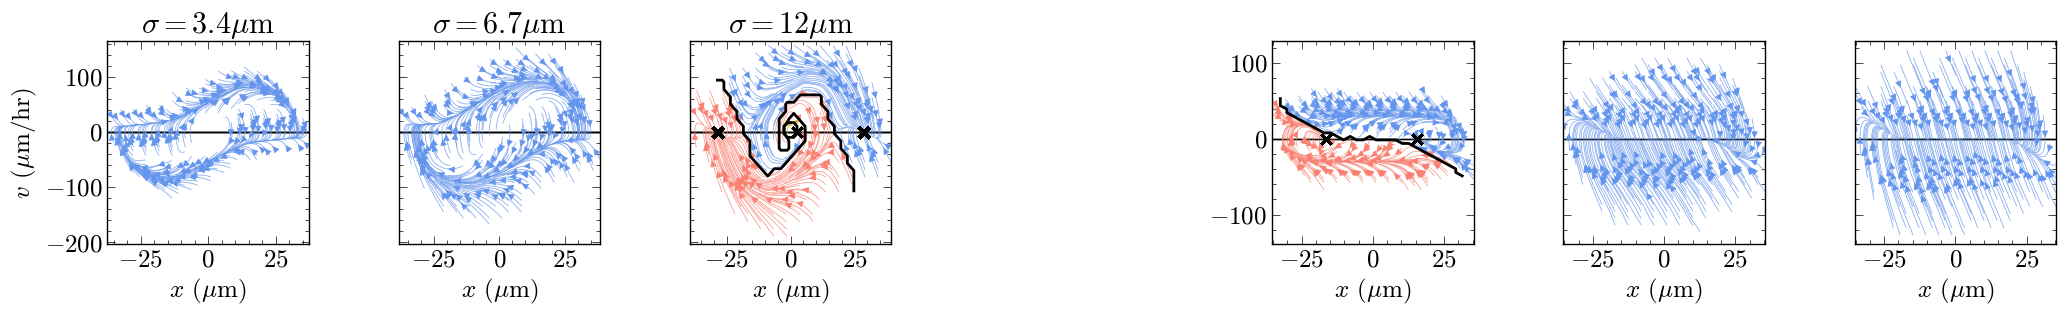

In [12]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

gids = [139, 10, 141, 10, 142, 26, 144]
titles = [
    r"$\sigma=3.4\mu \mathrm{m}$",
    r"$\sigma=6.7\mu \mathrm{m}$",
    r"$\sigma=12\mu \mathrm{m}$",
]

# streams
for ax, gid, title in zip(axs[:3], gids[:3], titles):
    streamplot(
        *process_gid(gid),
        ax,
        title=title,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        **kwargs
    )

for ax, gid in zip(axs[4:], gids[4:]):
    streamplot(
        *process_gid(gid),
        ax,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        # show_terminal=True,
        ignore_wheat=True,
        **kwargs | {"color": "cornflowerblue"}
    )

axs[0].clear()
axs[2].clear()
axs[4].clear()

streamplot(
    *process_gid(gids[0]),
    axs[0],
    n_skip=nskip,
    title=titles[0],
    zero_line=True,
    mix_corn_salmon=True,
    ignore_wheat=True,
    # show_terminal={"color": "black"},
    **kwargs
)
streamplot(
    *process_gid(gids[2]),
    axs[2],
    title=titles[2],
    n_skip=nskip,
    zero_line=True,
    # mix_corn_salmon=True,
    show_terminal={"color": "black"},
    septx=True,
    **kwargs
)

streamplot(
    *process_gid(gids[4]),
    axs[4],
    n_skip=nskip,
    zero_line=True,
    septx=True,
    # mix_corn_salmon=True,
    show_terminal={"color": "black"},
    **kwargs
)

axs[3].remove()
[axs[k].set_ylabel("") for k in range(1, ncols)]
[axs[k].sharey(axs[0]) for k in [1, 2]]
[axs[k].tick_params(labelleft=False) for k in [1, 2]]
[axs[k].sharey(axs[-1]) for k in [4, 5, 6]]
[axs[k].tick_params(labelleft=False) for k in [5, 6]]

plt.tight_layout()
render("paper_plots/varying_sigma_streams_noX.pdf")

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'wheat' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'wheat' 'salmon']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'salmon' 'wheat' 'cornflowerblue']
All unique colors: ['gainsboro' 'wheat' 'cornflowerblue' 'salmon']


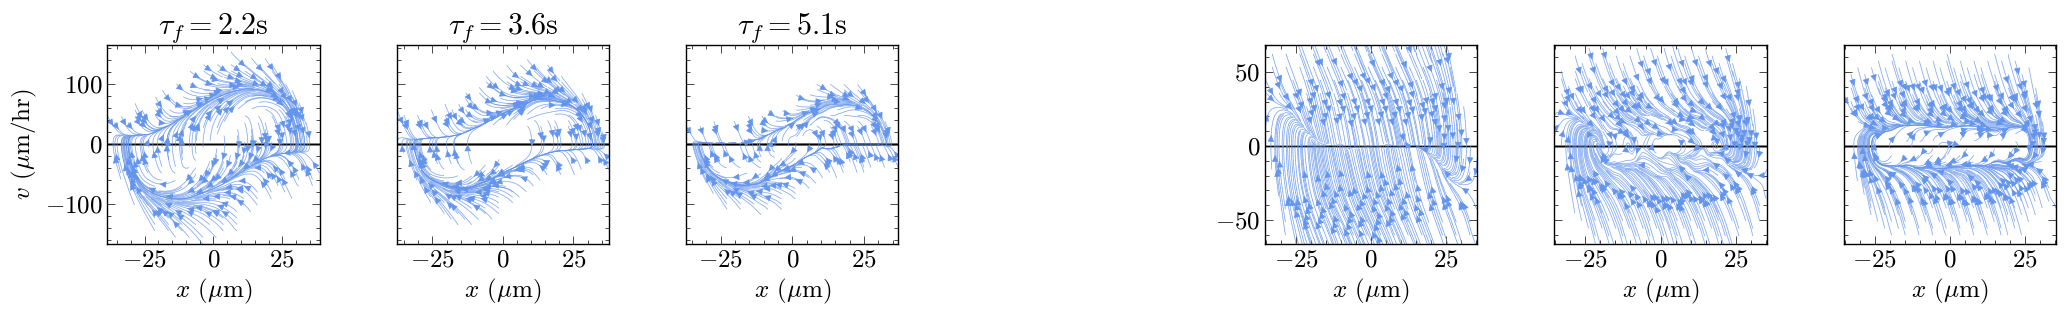

In [13]:
nrows, ncols = 1, 7
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

gids = [10, 145, 120, 10, 26, 146, 121]
titles = [
    r"$\tau_{f}=2.2\mathrm{s}$",
    r"$\tau_{f}=3.6\mathrm{s}$",
    r"$\tau_{f}=5.1\mathrm{s}$",
]

# streams
for ax, gid, title in zip(axs[:3], gids[:3], titles):
    streamplot(
        *process_gid(gid),
        ax,
        title=title,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        ignore_wheat=True,
        **kwargs
    )

for ax, gid in zip(axs[4:], gids[4:]):
    streamplot(
        *process_gid(gid),
        ax,
        n_skip=nskip,
        zero_line=True,
        mix_corn_salmon=True,
        # show_terminal=True,
        ignore_wheat=True,
        **kwargs | {"color": "cornflowerblue"}
    )


axs[3].remove()
[axs[k].set_ylabel("") for k in range(1, ncols)]
[axs[k].sharey(axs[0]) for k in [1, 2]]
[axs[k].tick_params(labelleft=False) for k in [1, 2]]
[axs[k].sharey(axs[-1]) for k in [4, 5, 6]]
[axs[k].tick_params(labelleft=False) for k in [5, 6]]

plt.tight_layout()
render("paper_plots/varying_tauf_streams.pdf")

### Fig. 5

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']
All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']


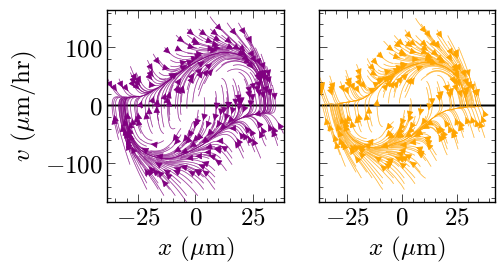

In [14]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 2.5 * nrows), sharey=True)

streamplot(
    *process_gid(10),
    axs[0],
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "purple"})
)
streamplot(
    *process_gid(100),
    axs[1],
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "orange"})
)
axs[1].set_ylabel("")
plt.subplots_adjust(wspace=0.2)

fig.savefig("paper_plots/filopodia_knx.pdf")

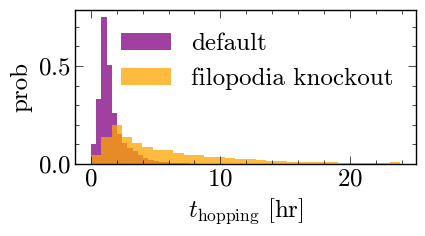

In [15]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4.6 * ncols, 2.7 * nrows))
hist_kwargs = {"density": True, "bins": 30, "alpha": 0.75}
cs = ["purple", "orange"]
lbs = ["default", "filopodia knockout"]
for k, x in enumerate(
    [
        np.load(
            "/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/defaults/hopping times/fulltake_gid10.npy"
        ),
        np.load(
            "/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/defaults/hopping times/fulltake_gid100.npy"
        ),
    ]
):
    axs.hist(x, **(hist_kwargs | {"color": cs[k], "label": lbs[k]}))
axs.set_ylabel("prob")
axs.set_xlabel(r"$t_{\mathrm{hopping}}\ [\mathrm{hr}]$")
axs.legend()
plt.tight_layout()
plt.savefig("paper_plots/filopodia_knx_hopping_times.pdf")

### Fig. 6

All unique colors: ['gainsboro' 'salmon' 'cornflowerblue']


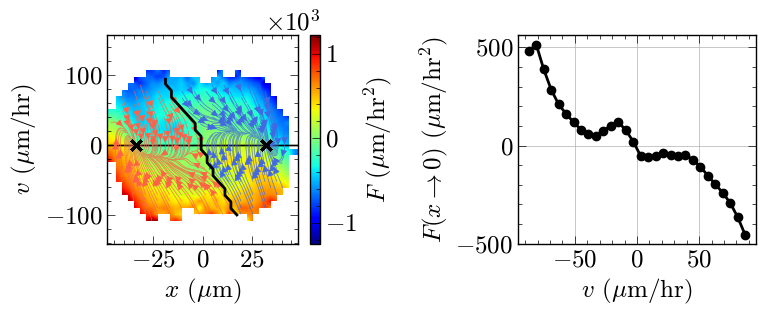

In [16]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))

heatmap(axs[0], *process_gid(4), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    *process_gid(4),
    axs[0],
    n_skip=nskip,
    zero_line=True,
    darker_shade=True,
    septx=True,
    show_terminal={"color": "black"},
    **kwargs
)
dynamicsplot(axs[1], *process_gid(4))

plt.tight_layout()
render("paper_plots/tauX_knx.pdf")

### Fig. 7

All unique colors: ['gainsboro' 'cornflowerblue' 'red' 'salmon']


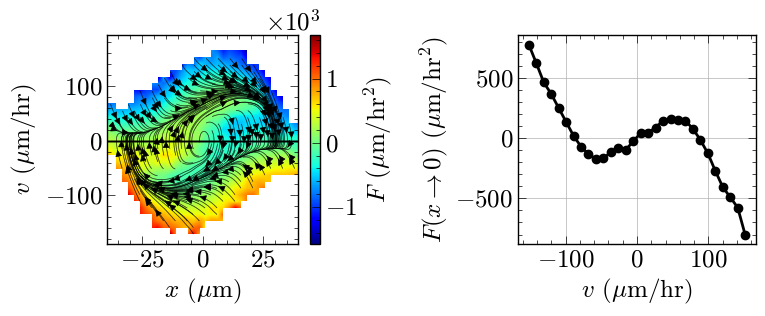

In [17]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))

heatmap(axs[0], *process_gid(13), xlabel=True, cbar=True, cbar_label=True)
streamplot(
    *process_gid(13),
    axs[0],
    n_skip=nskip,
    zero_line=True,
    **(kwargs | {"color": "black"})
)
dynamicsplot(axs[1], *process_gid(13))

plt.tight_layout()
fig.savefig("paper_plots/tension_knx.pdf")